## Displaying the Patterns Encoded By Filters'

We are going to take a look at the VG16 Network and use gradient ascent in the input space. 

This means that, from starting with a blank image, we apply gradient descent to the value of this input image of a convnet so as maximize the response of a specific filter. 
- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

In [4]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# Calling gradeints returns a list of tensors of size 1
# Therefore we only keep the first element
grads = K.gradients(loss, model.input)[0]

# We at 0.00001 to ensure we don't divide by 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# We start with a blank gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Size of each gradient step 
step = 1.

# We run for 40 steps
for i in range(40):
    # Calculates the loss and gradient values 
    loss_value, grads_value = iterate([input_img_data])
    
    # Adjusts the input image in the direction that maximizes loss
    input_img_data += grads_value * step

In [5]:
# Helper function that converts a tensor into an image
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### A function that generates the filters visualizations

In [6]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        img = input_img_data[0]
        
    return deprocess_image(img)

### Finally, plotting the filter pattern that the zeroth channel in layer block3_conv1 responds to maximally

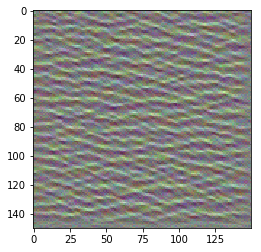

In [7]:
plt.imshow(generate_pattern('block3_conv1', 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


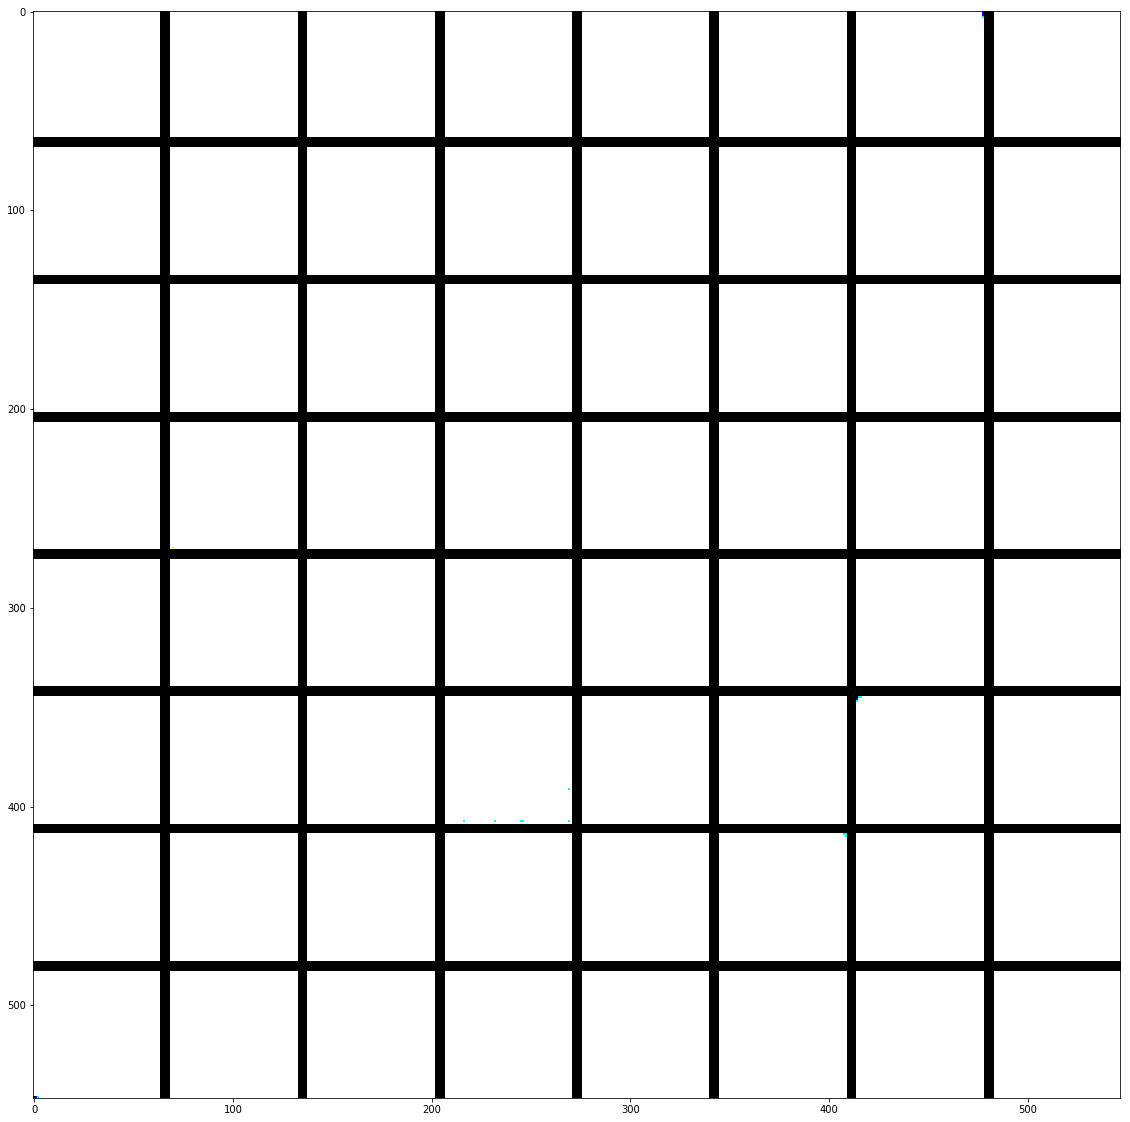

In [10]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
        vertical_start: vertical_end, :] = filter_img
        
plt.figure(figsize=(20, 20))
plt.imshow(results)